# Land use classification

*Author: Gregor Perich*

In this notebook, we'll take a look at how you can use `eodal` to perform land use classification on a coarse level using the [CORINE](https://land.copernicus.eu/pan-european/corine-land-cover) land cover map. The CORINE map depcits the land use from the years 2017-2018, as can be seen in the [metadata](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=metadata). We'll use an extract of the 2018 version of the CORINE land cover map. It features a spatial resolution of 100 m. This tutorial highlights the ability of `eodal` to integrate and work with different data sources. 

**Content**
- We'll use a `eodal` to query and extract Sentinel-2 scenes for the selected AOI
- Extract land cover classes from CORINE
- Extract time series data from S2 scenes 
- Train our own machine learning model for crop classification


In [4]:
# import libraries and set paths
# !pip install eodal

import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from eodal.config import get_settings
from eodal.core.sensors.sentinel2 import Sentinel2  # native support for Sentinel2
from eodal.core.raster import RasterCollection
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from typing import List
from pathlib import Path

base_dir: Path = Path('../')
# for MS planetary PC:
# base_dir: Path = Path('/home/jovyan/PlanetaryComputerExamples/')
data_dir: Path = Path(base_dir.joinpath("data"))
temp_dir: Path = Path(base_dir.joinpath("temp_files"))
model_dir: Path = Path(base_dir.joinpath("models"))

# Define settings, s.t. we can access the data from MS planetary computer
Settings = get_settings()
Settings.USE_STAC = True

# define our preprocessing function
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    
    # resample scene
    # default interpolation method is cv2.INTER_NEAREST_EXACT
    # but you can specify other methods from cv2 or your own
    ds.resample(inplace=True, target_resolution=target_resolution)
    
    # mask clouds, shadows, and snow
    # the defaults are SCL classes [1, 2, 3, 7, 8, 9, 10, 11]
    # but you can also specify your own list of classes
    ds.mask_clouds_and_shadows(inplace=True)
    
    return ds

Now, lets define our user input. The provided CORINE land cover map (under ../data/CORINE_2018_raster100m_Greifensee.tif) has ben cut down to a small (ca. 10 x 10 km) area of interest (AOI) around the lake Greifensee near Zürich, Switzerland. That way, we can reduce the computation time for our example. Also, we'll only use a small extract of the S2 time series (from April to June 2018), to keep computation time low. As we'll find out later, this has an adverse effect on our models' performance. We'll also set the target resolution of our S2 images to 50 m to speed up computation. As our land cover map is at 100 m resolution, this should be fine. We will also select the RGB and NIR bands only. 

In [5]:
# -------------------------- Collection -------------------------------
collection: str = "sentinel2-msi"

# ------------------------- Time Range ---------------------------------
time_start: datetime = datetime(2018, 4, 1)  # year, month, day (incl.)
time_end: datetime = datetime(2018, 6, 30)  # year, month, day (incl.)

# ---------------------- Spatial Feature  ------------------------------
geom: Path = Path(data_dir.joinpath("greifensee_bbox.gpkg"))
# for MS planetary PC
# geom: Path = Path("/home/jovyan/PlanetaryComputerExamples/data/greifensee_bbox.gpkg")

# ------------------------- Metadata Filters ---------------------------
# Filter for < 15% cloud cover to reduce the amount of scenes for easier computation
metadata_filters: List[Filter] = [
    Filter("cloudy_pixel_percentage", "<", 10),
    Filter("processing_level", "==", "Level-2A"),
]

# -------- Define kwargs for the scene constructor ---------------------
scene_kwargs = {
    "scene_constructor": Sentinel2.from_safe,
    "scene_constructor_kwargs": {"band_selection": ["B02", "B03", "B04", "B08"]},
    "scene_modifier": preprocess_sentinel2_scenes,  # our function from above
    "scene_modifier_kwargs": {"target_resolution": 50},
}

# query the scenes available (no I/O of scenes, this only fetches metadata)
feature = Feature.from_geoseries(gpd.read_file(geom).geometry)
mapper_configs = MapperConfigs(
    collection=collection,
    time_start=time_start,
    time_end=time_end,
    feature=feature,
    metadata_filters=metadata_filters,
)

# create a Mapper instance
mapper = Mapper(mapper_configs)

# fetch metadata
mapper.query_scenes()

In [6]:
# check how many scenes we have
meta_df = mapper.metadata
print(f"Number of scenes: {meta_df.shape[0]}")

Number of scenes: 6


Now, we can download the data. This may take a few minutes, depending on your internet connection.

In [7]:
# get actual data, this is the I/O step
mapper.load_scenes(scene_kwargs=scene_kwargs)

# store the data (type = SceneCollection) separately
scene_coll = mapper.data

2023-06-21 09:53:14,540 eodal        INFO     Starting extraction of sentinel2 scenes
2023-06-21 09:53:29,235 eodal        INFO     Finished extraction of sentinel2 scenes


## Prepare our land use data
Now, we have to prepare our land use data. We have a clipped extent of the CORINE 2018 land use data set. The resolution is 100 m and the data source is a `geojson` file, which contains the land use classes as vector data. 

To get an overview of the data, we'll plot the raster version first:

The raster has the following bands: ['B1']


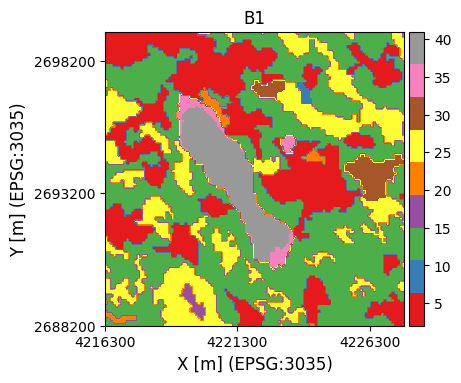

In [8]:
# read in raster file
fpath = data_dir.joinpath("CORINE_2018_raster100m_Greifensee.tif")

corine_raster = RasterCollection.from_multi_band_raster(fpath_raster=fpath)

# check the available bands of the raster
print(f"The raster has the following bands: {corine_raster.band_names}")

# plot the raster
corine_raster.plot_band("B1", colormap="Set1")
plt.tight_layout()

As the polygons (e.g. vectorized) version is easier to work with, we'll use this one for further processing. We load it as a `geopandas` data frame and take a look at the available classes, which are stored in the `Code_18` column.

In [9]:
# read in polygon version of the land use map
corine_polys = gpd.read_file(data_dir.joinpath("CORINE_2018_vector100m_Greifensee.geojson"))

# reproject to the CRS of our S2 images
corine_polys = corine_polys.to_crs("epsg:32632")

# display available land cover classes
corine_polys.Code_18.unique()

array(['313', '211', '112', '243', '142', '411', '231', '512', '121',
       '312', '111', '311', '131', '124', '324'], dtype=object)

You can see the land cover classes online [here](https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/html/). A table with the classes is given below. The three-digit code of the classes represents all three levels of the classification in one, from "left to right". E.g. class "211" means it's 2. Agricultural areas, 2.1. Arable land and 2.1.1. non-irrigated arable land.

<img src="../images_for_text/CORINE_land_cover_classes.png" width="500">

## Data prep
Now, we have to combine the S2 data with the polygon classes. For that, we'll do the following: 
- Extract the CORINE land use class for each pixel (in the same CRS as our S2 scenes)
- Extract the reflectance values along our S2 time series for each pixel
- Combine in a large data frame
- Train a machine learning model (we'll use a random forest)

### Extract CORINE land use class for each S2 pixel

We add the CORINE land use class to each pixel in our S2 CRS. That way, we can extract the S2 time series later and merge it to our target value (=the land use class)

In [10]:
# get a S2 scene from our collection
ts_scenes = scene_coll.timestamps
scene0 = scene_coll[ts_scenes[0]]

# get our scene into a geopandas data frame
scene0_gdf = scene0.to_dataframe()

In [11]:
import pandas as pd

# dissolve the polygons into one multipolygon per land use class
corine_dissolved = corine_polys.dissolve(by="Code_18")

# we have to reset the index, otherwise we cannot access the Code_18 column
corine_dissolved = corine_dissolved.reset_index()

# loop over these polys using clip
gdf_list = []
for idx, poly in corine_dissolved.iterrows():

    # clip the scene to the multi-polygon of each class
    class_raster = scene0.clip_bands(clipping_bounds=poly.geometry)

    # keep the information in a gdf
    class_gdf = class_raster.to_dataframe()

    # add class
    class_gdf["class"] = poly.Code_18

    # keep only the geometry and the class columns
    class_gdf = class_gdf.loc[:, ["geometry", "class"]]

    # add to list
    gdf_list.append(class_gdf)

# concat the dataframes
class_gdf = pd.concat(gdf_list)

In [12]:
class_gdf

,geometry,class
0,POINT (478380.000 5244080.000),111
1,POINT (478380.000 5244030.000),111
2,POINT (478430.000 5244180.000),111
3,POINT (478430.000 5244130.000),111
4,POINT (478430.000 5244080.000),111
...,...,...
3398,POINT (477830.000 5241830.000),512
3399,POINT (477830.000 5241780.000),512
3400,POINT (477830.000 5241730.000),512
3401,POINT (477830.000 5241680.000),512


Now we have - for each pixel in our S2 CRS - the CORINE land cover class. The next step is to merge this information with the S2 timeseries info. Below, we'll go through all of our extracted S2 scenes and read them out as a `geopandas` data frame, append the sensing date of the S2 scene and add (=merge) the class info. This step may take some minutes. 

In [13]:
# loop over the S2 scenes and add the corine land cover class to each pixel
i = 1
s2_gdf_list = []
for timestamp, scene in scene_coll:

    print(f"Processing scene {i} of {len(scene_coll)}")

    # convert to GDF
    scene_gdf = scene.to_dataframe()

    # add date
    scene_gdf["date"] = timestamp.date().strftime("%Y-%m-%d")

    # merge with the corine land cover class
    scene_gdf = scene_gdf.merge(class_gdf, on="geometry")

    ## append
    s2_gdf_list.append(scene_gdf)

    i += 1
    

Processing scene 1 of 6
Processing scene 2 of 6
Processing scene 3 of 6
Processing scene 4 of 6
Processing scene 5 of 6
Processing scene 6 of 6


In [14]:
s2_gdf_tot = pd.concat(s2_gdf_list)

# if you want, you can write this out as a CSV - The file is rather large...
# s2_gdf_tot.to_csv(temp_dir.joinpath("s2_gdf_tot.csv"))

### Model training
Now, we split 80% of our data into a training data set and keep 20% as the test data set. We'll choose a simple Random Forest model and won't perform cross-validation to save some computation time. You can experiment with your own models here or tweak the hyperparameters of the Random Forest classifier. Training the classifier took a few seconds on a 4-core CPU and uses around 3 GB RAM.

In [15]:
# import packages needed for modelling
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# set seed for reproducability
rand_state = 42

# 80/20 train test set split, random
rfr_train, rfr_test = train_test_split(s2_gdf_tot, train_size=0.8, test_size=0.2, random_state=rand_state)

# get X matrix (dependent variables) and y vector (target variable)
X_train, X_test = rfr_train.loc[:, ["B02", "B03", "B04", "B08"]], rfr_test.loc[:, ["B02", "B03", "B04", "B08"]]
y_train, y_test = rfr_train["class"], rfr_test["class"]

In [16]:
# set model hyperparameters
ml_model = RandomForestClassifier(n_estimators=100, # no. of trees
                                  max_features="sqrt", # no. of features to split at each node
                                  random_state=rand_state,  # for reproducibility
                                  n_jobs=-1,  # use all available CPU cores
                                  verbose=1 # give us more info on model training
                                 )

# train the model, this may take some time...
ml_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.1s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

### Check model performance
let us check how the model performed by predicting on the unseen test data set. We'll also create a confusion matrix so see which classes got classified well and which weren't. 

In [19]:
# get the overall accuracy of our predictor
oa_acc = ml_model.score(X_test, y_test)

print(f"The overall accuracy of our classifier is: {oa_acc:.2f}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s


The overall accuracy of our classifier is: 0.55


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


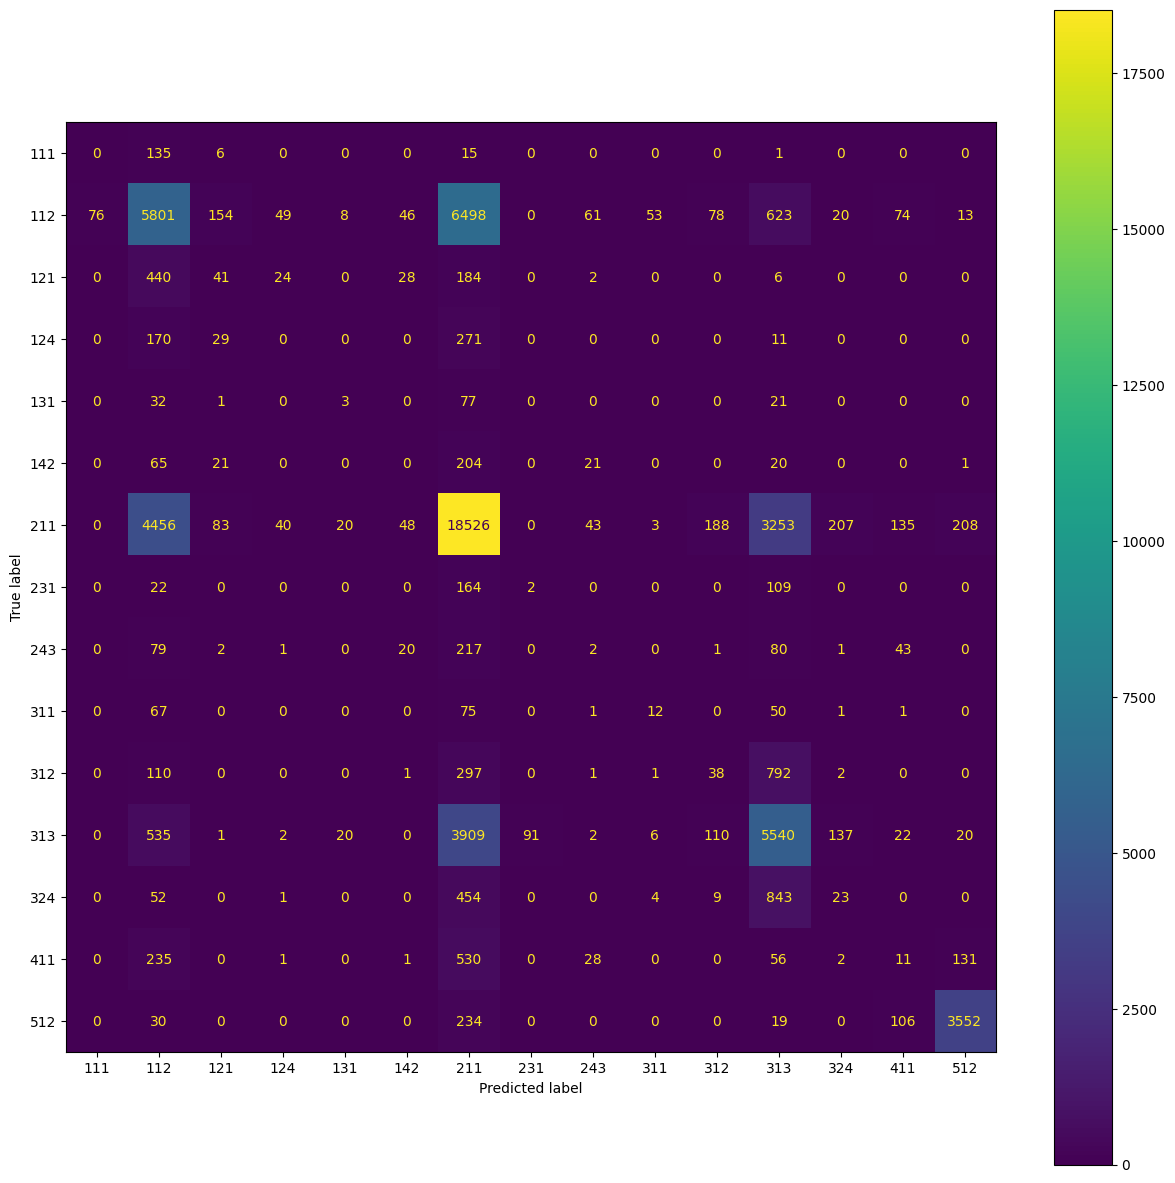

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get prediction and true Y vector
pred_vector = ml_model.predict(X_test)
true_vector = y_test

# create confusion matrix
conf_mat = confusion_matrix(true_vector, pred_vector, labels=ml_model.classes_)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=ml_model.classes_).plot(ax=ax)

The overall accuracy of our model isn't very good at 55%. But it comes as no surprise, as our model is very simple and covers a small area to keep computation low. Some suggestions to improve the model are: 
- Increase the data availability for the model by either enlarging the AOI or the time series
- Take time series information into account. Currently, all S2 data are pasted together.
- Tune the hyperparameters of the Random Forest algorithm.
- Choose another ML algorithm to improve the model performance. 

To get the best model performance, you'll need to tinker yourself. The power of `eodal` lies in making satellite data available for everyone. The hassle of satellite data pre-processing is taken away from you as the user. You can now fully focus on tweaking your models and to answer your research questions. 